In [106]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [137]:
# Import data
survey_data = pd.read_csv('nonvoters_data.csv')

In [138]:
# Make data categorical
survey_data = survey_data.astype('category')

# Remove meaningless survey inputs and questions not of interest
survey_data.loc[:,'Q2_1':'Q18_10'] = survey_data.loc[:,'Q2_1':'Q18_10'].replace(-1, np.nan)
survey_data.loc[:,'Q23':'Q27_6'] = survey_data.loc[:,'Q23':'Q27_6'].replace(-1, np.nan)
survey_data.loc[:,'Q30'] = survey_data.loc[:,'Q30'].replace(-1, np.nan)
survey_data.loc[:,'Q19_1':'Q19_10'] = survey_data.loc[:,'Q19_1':'Q19_10'].replace(-1,0)
survey_data = survey_data.drop(['Q20','Q21','Q22','Q28_1','Q28_1','Q28_2','Q28_3','Q28_4','Q28_5','Q28_6','Q28_7','Q28_8','Q29_1','Q29_2',\
                  'Q29_3','Q29_4','Q29_5','Q29_6','Q29_7','Q29_8','Q29_9','Q29_10','Q31','Q32','Q33', 'Q26'], axis = 1)
direct_voting_q = ['Q2_1','Q2_3','Q25','Q23','Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6']
survey_data = survey_data.drop(direct_voting_q, axis = 1)

# Remove rows with missing data
survey_data = survey_data.dropna(axis = 0)

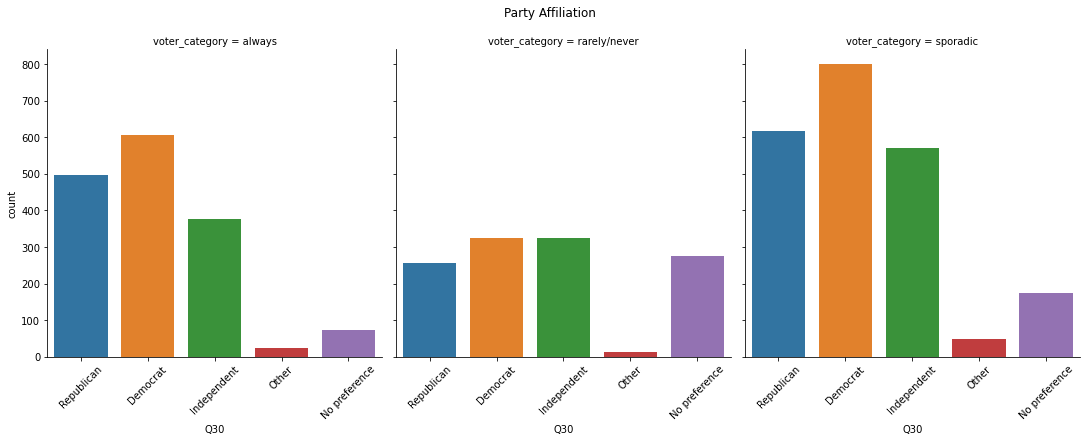

In [139]:
# Visualize Data
g = sns.catplot(x = "Q30", data = survey_data, col = 'voter_category', kind = 'count')
g.fig.suptitle("Party Affiliation", y=1.05)
g.set_xticklabels(['Republican','Democrat','Independent','Other', 'No preference'], rotation = 45)

In [142]:
# Check class frequency
survey_data.voter_category.value_counts()
# survey_data.shape

sporadic        2211
always          1577
rarely/never    1192
Name: voter_category, dtype: int64

In [143]:
# Need to downsample sporadic and always voters
from sklearn.utils import resample, shuffle

# Separate dataset by class
df_spor = survey_data[survey_data.voter_category == 'sporadic']
df_always = survey_data[survey_data.voter_category == 'always']
df_never = survey_data[survey_data.voter_category == 'rarely/never']

# Downsample majority classes without replacement
df_spor_ds = resample(df_spor, replace = False, n_samples = 1192, random_state = 25)
df_always_ds = resample(df_always, replace = False, n_samples = 1192, random_state = 25)

# Recombine datasets and shuffle
survey_data_ds = pd.concat([df_spor_ds, df_always_ds, df_never])
survey_data_ds = shuffle(survey_data_ds, random_state = 25)
survey_data_ds.voter_category.value_counts()

sporadic        1192
rarely/never    1192
always          1192
Name: voter_category, dtype: int64

In [144]:
# Need to encode string variables into integers
from sklearn.preprocessing import OrdinalEncoder

def encode_inputs(df, column, order='auto'):
    new_col_name = str(column + "_code")
    oe = OrdinalEncoder(categories = order)
    df[new_col_name] = oe.fit_transform(df[[column]])
    return df

survey_data_ds = encode_inputs(survey_data_ds, 'educ', [["High school or less", "Some college","College"]])
survey_data_ds = encode_inputs(survey_data_ds, 'income_cat', [["Less than $40k", "$40-75k","$75-125k","$125k or more"]])
survey_data_ds = encode_inputs(survey_data_ds, 'voter_category', [["rarely/never", "sporadic","always"]])
survey_data_ds = encode_inputs(survey_data_ds, 'race')
survey_data_ds = encode_inputs(survey_data_ds, 'gender')

In [153]:
# Split data intro trainging and testing set
from sklearn.model_selection import train_test_split

train, test = train_test_split(survey_data_ds, test_size = 0.2, random_state = 25)

X_train = train.iloc[:,2:89].drop(['educ','income_cat','voter_category','race','gender','ppage', 'voter_category_code'], axis=1)
y_train = train['voter_category_code']

X_test = test.iloc[:,2:89].drop(['educ','income_cat','voter_category','race','gender','ppage', 'voter_category_code'], axis=1)
y_test = test['voter_category_code']

In [158]:
# Feature selection using Chi-square test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

range_of_accuracies = []

for i in range(1,len(X_test.columns)):
    fs = SelectKBest(score_func = chi2, k=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    gnb = GaussianNB()
    gnb.fit(X_train_fs, y_train)
    X_test_fs = fs.transform(X_test)
    y_fitted = gnb.predict(X_test_fs)
    accuracy = accuracy_score(y_test, y_fitted)
    range_of_accuracies.append(accuracy*100)

num_features    55.000000
accuracies      51.536313
Name: 54, dtype: float64


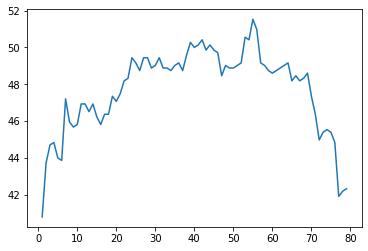

In [164]:
# Plot accuracies
num = np.array(range(1, len(range_of_accuracies)+1))
sqr = np.array(range_of_accuracies)

d = {'num_features': num, 'accuracies': sqr}
acc_num = pd.DataFrame(d)
sns.lineplot(x = num, y = sqr, data = acc_num)

# Find numbers of features giving maximum accuracyu
optimal_feat_length = acc_num.iloc[acc_num['accuracies'].idxmax()]
print(optimal_feat_length)

In [167]:
# Train model with number of features resulting in maximum accuracy
from sklearn.metrics import f1_score

fs = SelectKBest(score_func = chi2, k=55)
X_train_fs = fs.fit_transform(X_train, y_train)
gnb = GaussianNB()
gnb.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_fitted = gnb.predict(X_test_fs)

# Investigate F1 score of model
f1_score(y_test, y_fitted, average = None, labels = [0.0, 1.0, 2.0])
    

array([0.59423503, 0.32171582, 0.57565789])